In [20]:
import sys
sys.path.append('..')

In [21]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
def load_data(filepath='../data/with_padding/single/single-data-1734012132890502800.csv'):
    df = pd.read_csv(filepath, delimiter=';')
    # Convert concatenated bitstrings to a list of individual strings
    X = df['concatenated_bitstrings'].str.split(',').apply(lambda x: ''.join(x))
    # Convert binary strings to numpy arrays
    X = np.array([list(x) for x in X]).astype(int)
    y = df['num_excluded'].values
    return X, y

In [40]:
X, y = load_data()
print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Input shape: (1000, 62208)
Output shape: (1000,)
Training set shape: (800, 62208)
Test set shape: (200, 62208)


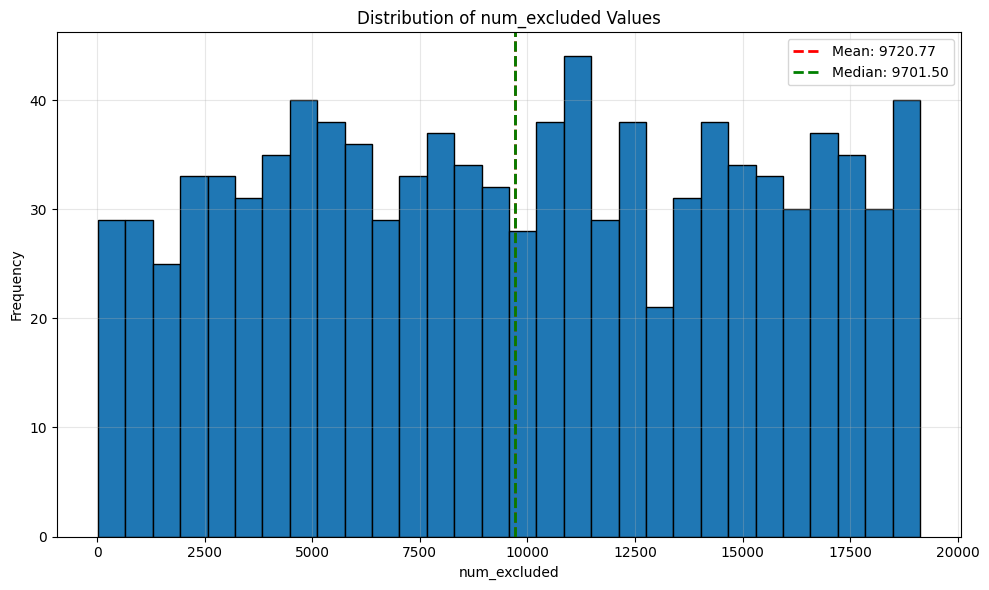

In [41]:
# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, edgecolor='black')
plt.title('Distribution of num_excluded Values')
plt.xlabel('num_excluded')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add vertical lines for mean and median
plt.axvline(np.mean(y), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(y):.2f}')
plt.axvline(np.median(y), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(y):.2f}')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
def create_model(input_dim):
    model = keras.Sequential([
        # Reduced first layer size significantly
        keras.layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        # More gradual reduction in layer sizes
        keras.layers.Dense(192, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        # Added L2 regularization to these layers
        keras.layers.Dense(64, activation='relu', 
                         kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(32, activation='relu',
                         kernel_regularizer=keras.regularizers.l2(0.01)),
        
        keras.layers.Dense(1)
    ])
    return model

model = create_model(X_train.shape[1])
model.summary()


C:\Users\Jonas.Gebele\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │    15,925,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 192)            │        49,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,012,481 (61.08 MB)

 Trainable params: 16,011,201 (61.08 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [43]:
# Add gradient clipping to prevent extreme updates
optimizer = keras.optimizers.Adam(
    learning_rate=0.01,
    clipnorm=1.0  # Clips gradients to prevent large updates
)

# Create more conservative learning rate scheduler
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # Only reduce by 10% each time (much slower reduction)
    patience=10,         # Wait longer before reducing
    min_delta=0.05,     # Require more significant improvement
    min_lr=0.0001,      # Your known good minimum
    verbose=1
)

model.compile(
    optimizer=optimizer,
    loss='huber',  # More robust to outliers than MSE
    metrics=['mae']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 9514.5498 - mae: 9513.8027 - val_loss: 8218.4229 - val_mae: 8217.6514 - learning_rate: 0.0100
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 9471.0566 - mae: 9470.2188 - val_loss: 9518.7061 - val_mae: 9517.5605 - learning_rate: 0.0100
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 9541.3252 - mae: 9540.0225 - val_loss: 9664.2764 - val_mae: 9662.4531 - learning_rate: 0.0100
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 9525.4902 - mae: 9523.4746 - val_loss: 9638.8848 - val_mae: 9636.2412 - learning_rate: 0.0100
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 9230.3027 - mae: 9227.4004 - val_loss: 9471.9277 - val_mae: 9468.1133 - learning_rate: 0.0100
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 8946.5361 - mae: 8942.3525 - val_loss: 9521.9023 - val_mae: 9516.4756 - learning_rate: 0.0100
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 8924.1191 - mae

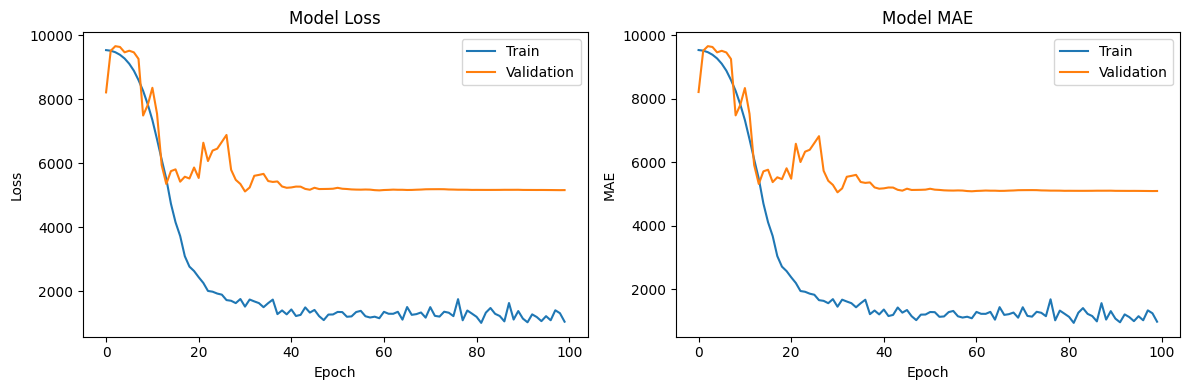

In [44]:
# Plotting training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [45]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss: 4523.5923
Test MAE: 4462.3394


In [46]:
import json

# Convert history.history dictionary to a format that can be saved
history_dict = history.history
# Convert numpy floats to regular floats for JSON serialization
history_dict = {k: [float(val) for val in v] for k, v in history_dict.items()}

# Save to JSON file
with open('training_history_padded.json', 'w') as f:
    json.dump(history_dict, f)

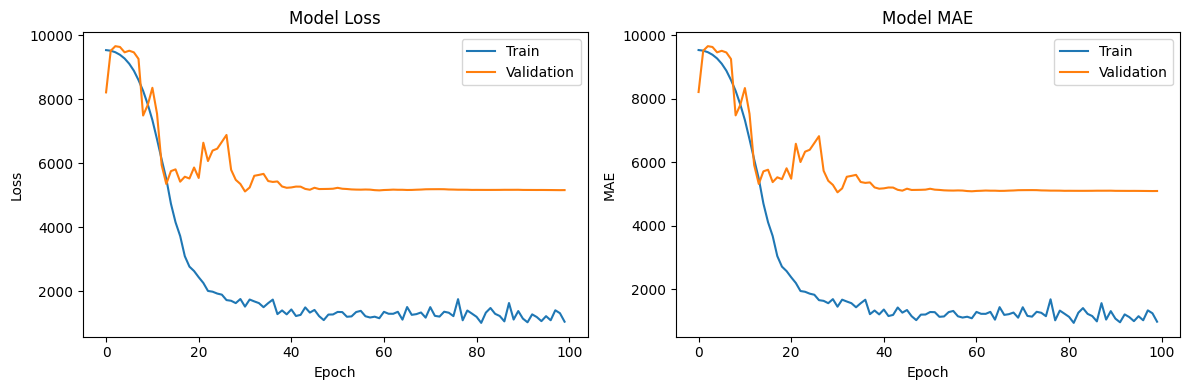

In [47]:
# Load the history
with open('training_history_unpadded.json', 'r') as f:
    history_dict = json.load(f)

# Create plots
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train')
plt.plot(history_dict['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train')
plt.plot(history_dict['val_mae'], label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

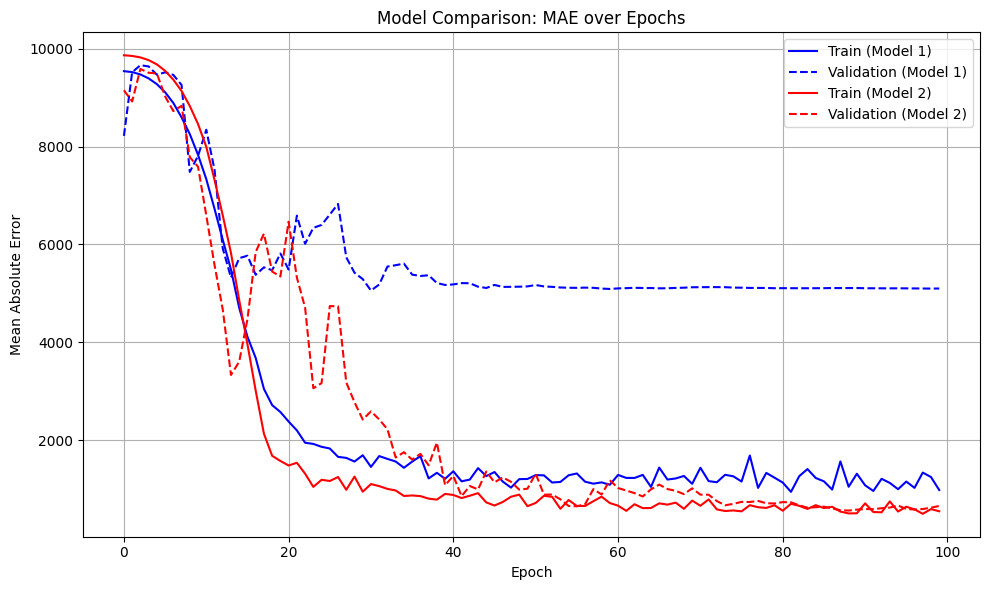

In [52]:
# Load both histories
with open('training_history_padded.json', 'r') as f:
    history_1 = json.load(f)

with open('training_history_unpadded.json', 'r') as f:
    history_2 = json.load(f)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot MAE for first model (nested under 'history')
plt.plot(history_1['history']['mae'], label='Train (Model 1)', color='blue', linestyle='-')
plt.plot(history_1['history']['val_mae'], label='Validation (Model 1)', color='blue', linestyle='--')

# Plot MAE for second model (direct access)
plt.plot(history_2['mae'], label='Train (Model 2)', color='red', linestyle='-')
plt.plot(history_2['val_mae'], label='Validation (Model 2)', color='red', linestyle='--')

# Customize the plot
plt.title('Model Comparison: MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()